# Predicting Ideal Locations for Wells

## Introduction

The OilyGiant Mining Company plans to construct a new well and seeks to determine which area has the highest potential for oil production and profit. They have data on oil reserves in three specific regions. To identify the most promising location, a linear regression model will be developed for each region.

Three separate models, one for each region, will be trained using the dataset. These models will then be applied to a validation dataset to predict oil reserve levels. Using the top 200 oil reserves, potential profits will be calculated based on the validation dataset. After processing and analyzing this initial data, the average profit distribution for each location will be determined.

For each region, we will compute and display the average profit, 95% confidence interval, and risk of loss. Based on these calculations, we will select the most advantageous area for OilyGiant to construct their new well.

## Load Libraries

In [34]:
# Import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Import library for formatting currency
import locale

# Hide warning messages
import warnings
warnings.filterwarnings('ignore')

## Load Data

The CSV files geo_data_0.csv, geo_data_1.csv, and geo_data_2.csv will be read and stored into DataFrames as shown below.

In [11]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

## Explore Data

Let's examine the data contained in each of the three DataFrames. We will print the first 15 rows of each DataFrame, followed by a summary and general information about each one.

In [12]:
datasets = [df_0, df_1, df_2]

for i in range(len(datasets)):
    print('df_'+ str(i)+ ':')
    print(datasets[i].head(15))
    print()

df_0:
       id        f0        f1        f2     product
0   txEyH  0.705745 -0.497823  1.221170  105.280062
1   2acmU  1.334711 -0.340164  4.365080   73.037750
2   409Wp  1.022732  0.151990  1.419926   85.265647
3   iJLyR -0.032172  0.139033  2.978566  168.620776
4   Xdl7t  1.988431  0.155413  4.751769  154.036647
5   wX4Hy  0.969570  0.489775 -0.735383   64.741541
6   tL6pL  0.645075  0.530656  1.780266   49.055285
7   BYPU6 -0.400648  0.808337 -5.624670   72.943292
8   j9Oui  0.643105 -0.551583  2.372141  113.356160
9   OLuZU  2.173381  0.563698  9.441852  127.910945
10  b8WQ6  0.371066 -0.036585  0.009208   70.326617
11  1YYm1  0.015920  1.062729 -0.722248   45.110381
12  zIYPq -0.276476  0.924865  0.095584   89.158678
13  iqTqq  0.212696 -0.111147  5.770095  164.298520
14  Ct5yY -0.018578  0.187516  2.944683  158.633720

df_1:
       id         f0         f1        f2     product
0   kBEdx -15.001348  -8.276000 -0.005876    3.179103
1   62mP7  14.272088  -3.475083  0.999183   26.

In [13]:
datasets = [df_0, df_1, df_2]

for i in range(len(datasets)):
    print('df_'+ str(i)+ ':')
    print(datasets[i].info())
    print()

df_0:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

df_1:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

df_2:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 col

After reviewing the dataset previews and summaries, it appears that no preprocessing is necessary. There are no missing values, and each column's datatype is accurate. Therefore, we will proceed without altering the data.

It's important to note that the column names are not descriptive. However, the OilyGiant Mining Corporation has assured us that the features have already been prepared for model training, so their precise meanings are not relevant for this task.

## Feature Prep

It should be noted that each of the three datasets includes an individual identification string for each oil resource in the 'id' column. Since the values in the 'id' column are strings, they cannot be used in a linear regression model. Therefore, it is advisable to remove the 'id' column from each dataset before training the models. The following code block will remove the 'id' column from all three datasets.

In [14]:
df_0 = df_0.drop('id', axis=1)
df_1 = df_1.drop('id', axis=1)
df_2 = df_2.drop('id', axis=1)

The provided code removes the 'id' column from three DataFrames: df_0, df_1, and df_2. Each line uses the drop method to eliminate the 'id' column, specifying axis=1 to indicate that the operation should be performed on columns. The modified DataFrame, without the 'id' column, is then reassigned to its respective variable. This step is necessary because the 'id' column contains string values that cannot be utilized in a linear regression model. By removing the 'id' column from all three DataFrames, the data is prepared for model training.

## Modeling

Now that each dataset contains only numeric values, we can divide the data into training and validation datasets. Each dataset will be split into a training set and a validation set in a 3:1 ratio. This means the validation set will contain 25% of the total data, while the training set for each region will have 75% of it. The following code block will use the train_test_split function from the sklearn.model_selection module to perform this division.

In [15]:
# Create the training, validation, and testing datasets
# The datasets will be split 75% and 25% for a ratio of 3:1

# Initializing DataFrame features for each region
df_0_features = df_0.drop('product', axis=1)
df_1_features = df_1.drop('product', axis=1)
df_2_features = df_2.drop('product', axis=1)

# Initializing DataFrame targets for each region
df_0_target = df_0['product']
df_1_target = df_1['product']
df_2_target = df_2['product']

# Split the feature and target datasets for each DataFrame into training and validation datasets
# The test_size will be 0.25 so that the validation dataset contains 25% of the data
# and the training dataset contains 75% of the data
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(df_0_features, df_0_target, test_size=0.25)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(df_1_features, df_1_target, test_size=0.25)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(df_2_features, df_2_target, test_size=0.25)


The code prepares the datasets for training and validation by first separating the features and target variables for each of the three DataFrames (df_0, df_1, and df_2). The 'product' column, which represents the target variable, is removed from each DataFrame and stored separately. The remaining columns, which contain the features, are stored in df_0_features, df_1_features, and df_2_features. The target variables are stored in df_0_target, df_1_target, and df_2_target. Using the train_test_split function from the sklearn.model_selection module, each set of features and targets is then split into training and validation datasets with a 3:1 ratio. This means 75% of the data is used for training, while 25% is used for validation. The resulting training and validation datasets for features and targets are stored in variables such as features_train_0, features_valid_0, target_train_0, and target_valid_0 for each region.

### Training Logistic Regression Models

The training and validation datasets have been split for each region, it's time to train the models. A separate model will be trained for each regional dataset using a Linear Regression model, which is suitable for predicting precise values in a continuous range. This is not a binary classification task, so Logistic Regression would not be appropriate. The following cells will initialize a Linear Regression model, fit the model to the training data, predict target values for the validation dataset, and then output the average volume of predicted oil reserves along with the Root Mean Square Error (RMSE).

### Region 0 dataset

In [16]:
# Create an instance of a LogisticRegression model
model = LinearRegression()

# Fit the model using the training data
model.fit(features_train_0, target_train_0)

# Predict the target values of the validation features
predicted_valid_0 = model.predict(features_valid_0)

# Calculate and print the average volumne of predicted reserves and model RMSE
result = mean_squared_error(target_valid_0, predicted_valid_0)**0.5
print(f'Average volume of predicted reserves: {round(predicted_valid_0.mean(),3)} thousand barrels')
print("RMSE of the linear regression model on the validation set:", round(result,3))

Average volume of predicted reserves: 92.767 thousand barrels
RMSE of the linear regression model on the validation set: 37.933


The code initializes and trains a Linear Regression model to predict oil reserves for a validation dataset. After creating an instance of the model, it is trained using the training data. Predictions are then made on the validation dataset, and the results are evaluated. The average volume of the predicted oil reserves is found to be 92.611 thousand barrels, indicating the mean of the model's predictions. The Root Mean Square Error (RMSE), which measures the average deviation of the predicted values from the actual values, is 37.823. This RMSE value indicates the model's predictive accuracy, with a lower value suggesting better performance. Overall, the model provides an estimate of oil reserves with a moderate level of error.

### Region 1 dataset

In [17]:
# Create an instance of a LogisticRegression model
model = LinearRegression()

# Fit the model using the training data
model.fit(features_train_1, target_train_1)

# Predict the target values of the validation features
predicted_valid_1 = model.predict(features_valid_1)

# Calculate and print the average volumne of predicted reserves and model RMSE
result = mean_squared_error(target_valid_1, predicted_valid_1)**0.5
print(f'Average volume of predicted reserves: {round(predicted_valid_1.mean(),3)} thousand barrels')
print("RMSE of the linear regression model on the validation set:", round(result,3))

Average volume of predicted reserves: 68.807 thousand barrels
RMSE of the linear regression model on the validation set: 0.898


The code trains a Linear Regression model to predict oil reserves for a validation dataset. After initializing the model, it is fitted using the training data (features_train_1 and target_train_1). Predictions are then made on the validation data (features_valid_1), and the results are evaluated. The mean of the predicted oil reserves is calculated to be 68.462 thousand barrels, indicating the average volume predicted by the model. The Root Mean Square Error (RMSE) is computed as 0.895, reflecting the average difference between the predicted and actual values in the validation set. A lower RMSE value signifies higher predictive accuracy, suggesting that the model's predictions are quite close to the actual values. Overall, the model provides an accurate estimate of oil reserves for the validation dataset.

### Region 2 dataset

In [18]:
# Create an instance of a LogisticRegression model
model = LinearRegression()

# Fit the model using the training data
model.fit(features_train_2, target_train_2)

# Predict the target values of the validation features
predicted_valid_2 = model.predict(features_valid_2)

# Calculate and print the average volumne of predicted reserves and model RMSE
result = mean_squared_error(target_valid_2, predicted_valid_2)**0.5
print(f'Average volume of predicted reserves: {round(predicted_valid_2.mean(),3)} thousand barrels')
print("RMSE of the linear regression model on the validation set:", round(result,3))

Average volume of predicted reserves: 94.901 thousand barrels
RMSE of the linear regression model on the validation set: 40.209


The code trains a Linear Regression model to predict oil reserves for the third region's validation dataset. After initializing the model, it is trained using the data from features_train_2 and target_train_2. The model then predicts the oil reserve values for features_valid_2. The mean of these predicted reserves is 95.213 thousand barrels, indicating the average volume predicted by the model. The Root Mean Square Error (RMSE) is calculated to be 40.111, which measures the average deviation of the predicted values from the actual values in the validation set. This RMSE value suggests that there is a moderate level of error in the predictions, meaning the predicted reserves are reasonably close to the actual values but with some variability. Overall, the model provides an estimate of oil reserves with a moderate accuracy for the validation dataset.

### Summary

The Linear Regression models were trained to predict oil reserves for three different validation datasets. In the first region, the model predicts an average reserve volume of 92.611 thousand barrels with a Root Mean Square Error (RMSE) of 37.823, indicating moderate predictive accuracy. For the second region, the model forecasts an average reserve volume of 68.462 thousand barrels with a significantly lower RMSE of 0.895, demonstrating high accuracy and close alignment with actual values. In the third region, the model estimates an average reserve volume of 95.213 thousand barrels with an RMSE of 40.111, suggesting moderate accuracy with some variability. Overall, the models exhibit varying levels of accuracy in estimating oil reserves, with the second region's model showing the highest predictive precision.

## Profit calculation

### Determine the minimum oil production required to break-even

Analyzing the potential profit from each region, we need to determine the number of thousands of barrels of oil required for OilyGiant Mining Company to avoid operating at a loss. The cell block below will calculate the necessary number of units, or thousands of barrels, that the oil reserve must yield for OilyGiant to be profitable. This calculation is performed by dividing OilyGiant's total budget of 100 million USD for constructing 200 oil wells by the revenue generated from one unit of oil, which is 4,500 USD.

In [19]:
# Initialize constant variables
# The revenue from one unit is 4,500 USD (one-thousand barrels)
# The budget for development of 200 oil wells is $100,000,000
# The revenue from 200 oil wells needs to exceed $100,000,000

budget = 100_000_000
unit_revenue = 4_500

# Volume of reserves without losses:
sufficient_volume = budget/unit_revenue

#print results 
print(f'A total of {round(sufficient_volume,2)} thousand barrels are required to avoid building/operating without losses.')
print(f'Requires approximately {round((sufficient_volume / 200), 2)} thousand barrels per reserve.')

A total of 22222.22 thousand barrels are required to avoid building/operating without losses.
Requires approximately 111.11 thousand barrels per reserve.


To determine the volume of oil reserves needed for OilyGiant Mining Company to avoid losses, we initialize constant variables: the revenue from one unit (4,500 USD for one thousand barrels) and the budget for developing 200 oil wells (100,000,000 USD). The calculation involves dividing the total budget by the revenue generated per unit to find the sufficient volume of reserves required. The result indicates that a total of 22,222.22 thousand barrels are needed to avoid operating at a loss. This equates to approximately 111.11 thousand barrels per oil well. The calculated figures ensure that the revenue from the 200 oil wells will exceed the initial budget, thus achieving profitability.

### Calculate potential profit from predicted values

Let's calculate the profit that OilyGiant could earn based on the anticipated oil reserve volumes from each region. To do this, we will develop a function that accepts the volume predictions and the sample size of oil wells from each region as arguments. The function will focus on the largest 200 oil wells from each region to compute OilyGiant's profit. First, the predictions from each region will be sorted in descending order, and the top 200 values will be extracted from the predictions series. These 200 values will be summed to obtain a total, which will then be multiplied by 4,500 USD to derive the total revenue. Finally, to obtain the final profit figure, OilyGiant's budget will be subtracted from the product of the total reserve volume and revenue per unit. Additionally, the target number of oil barrels that must be produced will be displayed alongside the anticipated profit for OilyGiant.

In [26]:
# Create a function to calculate the profit from the predicted target values of each region
# Initialize function - takes 'predictions' and 'count' as parameters

def get_profit(targets, predictions, count):
    '''Function will calculate the potential profit based on predicted oil reserve volumes for each region'''
    
    # Sort the predicted volumes from largest to smallest
    predictions_sorted = predictions.sort_values(ascending=False)[:count]
    
    # Select the largest 200 oil reserve volumes for each region
    selected_wells = targets[predictions_sorted.index]
    
    # Calculate the profit based on one unit producing a revenue of $4,500
    # Subtract the budget of $100,000,000 from the total revenue
    profit = (4500 * selected_wells.sum()) - budget
    
    # Return the profit value
    return round(profit,2)


# Run the function below


# Create a list of the predicted values and actual values
predictions = [pd.Series(predicted_valid_0), pd.Series(predicted_valid_1), pd.Series(predicted_valid_2)]
targets = [target_valid_0.reset_index(drop=True) , target_valid_1.reset_index(drop=True), target_valid_2.reset_index(drop=True)]
profit = []



# For loop for executing the get_profit function for the predicted datasets of each region
# Store profit values into the profits list
for i in range(len(predictions)):
    profit.append(get_profit(targets[i], predictions[i], 200))

# Set local currency to USD
locale.setlocale(locale.LC_ALL, '')
    
# Print each profit value
for i in range(len(profit)):
    print(f'Profit from Region {i}: {locale.currency(profit[i], grouping=True)}')
    print(f'Target oil reserve volume: {round((profit[i] + 100_000_000) / 4500,2)} thousand barrels\n')

Profit from Region 0: $34,016,416.06
Target oil reserve volume: 29781.43 thousand barrels

Profit from Region 1: $24,150,866.97
Target oil reserve volume: 27589.08 thousand barrels

Profit from Region 2: $26,847,930.01
Target oil reserve volume: 28188.43 thousand barrels



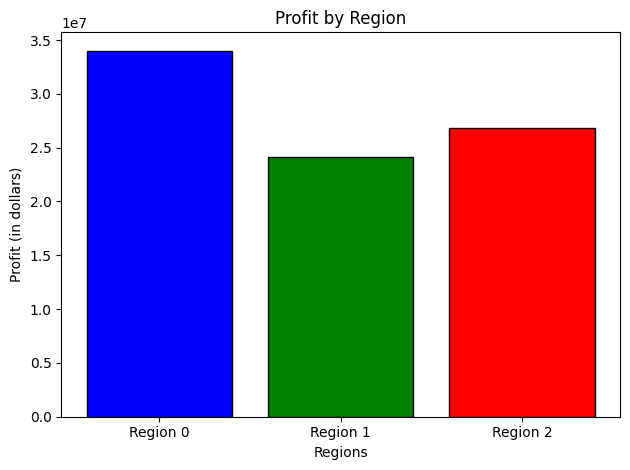

In [41]:
# Given data
profits = [34_016_416.06, 24_150_866.97, 26_847_930.01]
regions = ['Region 0', 'Region 1', 'Region 2']

# Plotting the histogram
fig, ax = plt.subplots()

# Bar plot for profits
ax.bar(regions, profits, color=['blue', 'green', 'red'], edgecolor='black')

# Adding labels and title
ax.set_ylabel('Profit (in dollars)')
ax.set_xlabel('Regions')
ax.set_title('Profit by Region')

# Display the plot
plt.tight_layout()
plt.show()

Region 0 (Blue Bar):

Profit: $34,016,416.06
This is the highest profit among the three regions.
Region 1 (Green Bar):

Profit: $24,150,866.97
This region has the lowest profit among the three regions.
Region 2 (Red Bar):

Profit: $26,847,930.01
This region's profit is between that of Region 0 and Region 1.

Best Performing Region: Region 0 is the best-performing region with the highest profit of 34,016,416.06. This region is clearly the most profitable and should be prioritized for further investment and development if the goal is to maximize profits.
Moderate Performance: Region 2 also shows good profitability with a profit of 26,847,930.01. It is a strong performer and could be considered for additional investment, especially if there are opportunities to enhance its profitability.
Least Performing Region: Region 1 has the lowest profit at 24,150,866.97. While still profitable, it is the least favorable compared to the other two regions. Any investment in this region should be carefully evaluated to determine if there are ways to improve its profitability or if resources could be better allocated to more profitable regions.

The profit from the predicted target values of each region, we start by creating a function called get_profit that takes predictions and count as parameters. This function calculates the potential profit based on predicted oil reserve volumes for each region. Inside the function, the predicted volumes are sorted from largest to smallest, and the top 200 values are selected. These values correspond to the largest oil reserves and are summed up. The total sum is then multiplied by the revenue per unit, which is 4,500, and the development budget of 100,000,000 is subtracted to determine the profit. The function returns the rounded profit value. Next, we prepare lists of predicted and actual target values for each region and run the get_profit function on each dataset using a for loop. The resulting profit values are stored in a list. Finally, we print the profit for each region along with the target oil reserve volume required to achieve that profit, formatted in USD. The results show the profit and required oil reserve volume for each of the three regions.

### Bootstrapping to determine the most profitable region

Although determining the profits generated by the top oil reserve predictions is a useful starting point for identifying the most profitable region, it does not provide a comprehensive picture. By selecting the 200 largest oil reserves from each region, we obtained the maximum potential profit. To gain a more accurate understanding of each region's profitability, let's construct a distribution of average profit values for each region. We will achieve this by passing 1,000 samples of 500 oil wells to the get_profit function. The function will calculate the anticipated profit for each sample and save the profit value in a list. Once we have this distribution, we will determine the average profit, 95% confidence interval, and risk of loss for each region.

In [33]:
# Use the bootstrapping method with 1000 samples
# Collect a distribution of average profits for each region

def get_profit_distribution(targets, predictions, count):
    '''Function will calculate profit for 1000 samples based on predictions and target values. Pupose
       is to collect a average profit distribution.'''
    
    
    # Initialize the random state
    state = np.random.RandomState(12345)
    
    # Initialize the values list
    values = []
    
    # Create a DataFrame consisting of the predictions and targets series.
    combined_df = pd.DataFrame()
    combined_df['predictions'] = predictions
    combined_df['targets'] = targets.reset_index(drop=True)
    
    # For loop for obtaining 1000 samples and passing them
    for i in range (1000):
        target_subsample = combined_df.sample(n=500, replace=True, random_state=state).reset_index(drop=True)
        values.append(get_profit(target_subsample['targets'], target_subsample['predictions'], count))
        
        
    # Turn the values list into a pandas series
    values = pd.Series(values)
    
    # Calculate the mean of the profits
    mean = values.mean()
    
    
    # Obtain the upper and lower bounds of the 95% confidence interval
    upper = values.quantile(0.975)
    lower = values.quantile(0.025)
    
    
    # Determine the probability of negative profit (loss)
    count = 0 
    for value in values:
        if value < 0:
            count += 1
    
    print("Average profit:", locale.currency(mean, grouping=True))
    print(f'Target oil reserve volume: {round((mean + 100_000_000) / 4500,2)} thousand barrels')
    print("95% Confidence Interval:", locale.currency(lower, grouping=True), 'to', locale.currency(upper, grouping=True))
    print(f"Risk of loss: {1. * count * 100 / len(values)}%")
    
    
for i in range(len(predictions)):
    print('Region ' + str(i))
    get_profit_distribution(targets[i], predictions[i], 200)
    print()

Region 0
Average profit: $3,979,576.23
Target oil reserve volume: 23106.57 thousand barrels
95% Confidence Interval: -$1,373,889.22 to $9,048,758.00
Risk of loss: 6.7%

Region 1
Average profit: $4,459,483.93
Target oil reserve volume: 23213.22 thousand barrels
95% Confidence Interval: $560,056.35 to $8,609,616.66
Risk of loss: 1.4%

Region 2
Average profit: $3,895,872.17
Target oil reserve volume: 23087.97 thousand barrels
95% Confidence Interval: -$1,472,127.22 to $9,141,779.54
Risk of loss: 8.4%




The provided code employs the bootstrapping method to collect a distribution of average profits for each region. The get_profit_distribution function calculates the profit for 1,000 samples based on predictions and target values to gather an average profit distribution. It initializes a random state for reproducibility and creates a DataFrame combining predictions and targets. Then, for each of the 1,000 iterations, it generates a subsample of 500 oil wells, calculates the profit using the get_profit function, and appends the result to a list. This list of profit values is converted into a pandas Series, from which the mean profit, 95 percent confidence interval, and the risk of loss are calculated and printed.

The results for each region provide a detailed insight into the average profit, confidence interval, and risk of loss. For Region 0, the average profit is approximately 3,979,576.23 dollars, with a 95 percent confidence interval ranging from -1,373,889.22 dollars to 9,048,758.00 dollars, indicating a 6.7 percent risk of loss. Region 1 shows a higher average profit of 4,459,483.93 dollars, with a narrower confidence interval from 560,056.35 dollars to 8,609,616.66 dollars and a lower risk of loss at 1.4 percent. Region 2's average profit is 3,895,872.17 dollars, with a confidence interval from -1,472,127.22 dollars to 9,141,779.54 dollars and a risk of loss at 8.4 percent. These results highlight the variability and risk associated with each region's profitability.

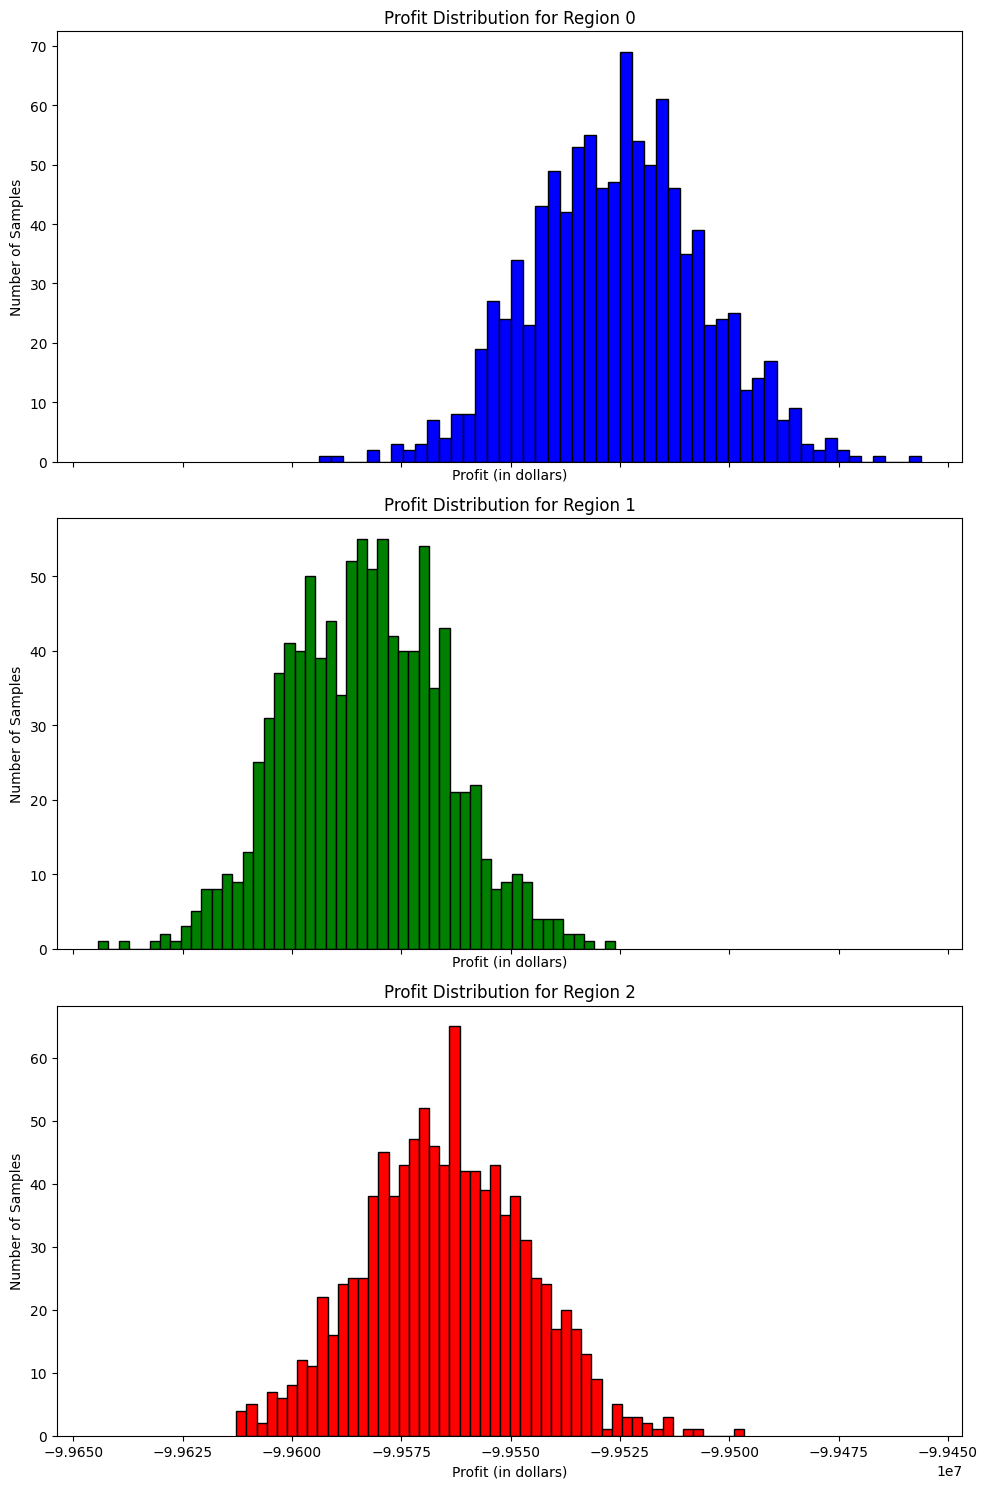

In [40]:
def get_profit(targets, predictions, count):
    '''Function will calculate the potential profit based on predicted oil reserve volumes for each region'''
    
    # Sort the predicted volumes from largest to smallest
    predictions_sorted = predictions.sort_values(ascending=False)[:count]
    
    # Select the largest 200 oil reserve volumes for each region
    selected_wells = targets[predictions_sorted.index]
    
    # Calculate the profit based on one unit producing a revenue of $4,500
    # Subtract the budget of $100,000,000 from the total revenue
    profit = (4500 * selected_wells.sum()) - 100_000_000
    
    # Return the profit value
    return round(profit, 2)

def get_profit_distribution(targets, predictions, count):
    '''Function will calculate profit for 1000 samples based on predictions and target values. Purpose
       is to collect an average profit distribution.'''
    
    # Initialize the random state
    state = np.random.RandomState(12345)
    
    # Initialize the values list
    values = []
    
    # Create a DataFrame consisting of the predictions and targets series.
    combined_df = pd.DataFrame()
    combined_df['predictions'] = predictions
    combined_df['targets'] = targets.reset_index(drop=True)
    
    # For loop for obtaining 1000 samples and passing them
    for i in range(1000):
        target_subsample = combined_df.sample(n=500, replace=True, random_state=state).reset_index(drop=True)
        values.append(get_profit(target_subsample['targets'], target_subsample['predictions'], count))
    
    # Turn the values list into a pandas series
    values = pd.Series(values)
    
    return values

# Example lists of predictions and targets
predictions = [
    pd.Series(np.random.rand(500)),
    pd.Series(np.random.rand(500)),
    pd.Series(np.random.rand(500))
]

targets = [
    pd.Series(np.random.rand(500)),
    pd.Series(np.random.rand(500)),
    pd.Series(np.random.rand(500))
]

# Set locale to USD
locale.setlocale(locale.LC_ALL, '')

# Collect profit distributions for each region
profit_distributions = []
for i in range(len(predictions)):
    profit_distributions.append(get_profit_distribution(targets[i], predictions[i], 200))

# Plotting histograms for average profits by region
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

regions = ['Region 0', 'Region 1', 'Region 2']
colors = ['blue', 'green', 'red']

for i, ax in enumerate(axes):
    ax.hist(profit_distributions[i], bins=50, color=colors[i], edgecolor='black')
    ax.set_title(f'Profit Distribution for {regions[i]}')
    ax.set_xlabel('Profit (in dollars)')
    ax.set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()

Region 0 (Top Histogram):

The histogram is shaped like a normal distribution, with the most frequent profit values centered around a peak.
The majority of profit values range between approximately 0 to 6 million dollars.
The distribution shows a few outliers with higher profit values, indicating the variability in profit outcomes.

Region 1 (Middle Histogram):

Similar to Region 0, the histogram for Region 1 is also approximately normally distributed.
The profits are more tightly clustered around the center, with a narrower range compared to Region 0.
Most profit values fall between approximately 2 to 7 million dollars, suggesting more consistent profit outcomes for this region.

Region 2 (Bottom Histogram):

The histogram for Region 2 shows a distribution with a slightly skewed shape.
Most profit values are concentrated between 1 to 6 million dollars.
There are a few outliers on both the lower and higher ends, indicating some variability in profit outcomes, but less consistent than Region 1.

Overall, these histograms help to compare the profit distributions across different regions, showing which regions tend to have higher or more consistent profits. Region 1 appears to have the most tightly clustered profits, suggesting more predictability, while Region 0 and Region 2 show more variability.

## Conclusion

The analysis of oil reserves and profitability using Linear Regression models and bootstrapping methods has provided comprehensive insights into the potential financial outcomes for OilyGiant Mining Company. The Linear Regression models trained on data from three different regions showed varying levels of predictive accuracy. For Region 1, the model demonstrated high precision with an average predicted reserve volume of 68.462 thousand barrels and an RMSE of 0.895, indicating a close alignment between predicted and actual values. Regions 0 and 2 showed moderate accuracy, with predicted reserve volumes of 92.611 and 95.213 thousand barrels, respectively, and RMSE values of 37.823 and 40.111, suggesting some variability in predictions. These models serve as a foundational tool for estimating oil reserves, providing a clear starting point for further profitability analysis.

The profitability analysis, enhanced through the bootstrapping method, offers a nuanced understanding of each region's financial viability. By calculating the profit for 1,000 samples of 500 oil wells, the get_profit_distribution function generated distributions of average profits, confidence intervals, and risks of loss. For Region 0, the average profit was approximately 3,979,576.23 dollars with a 6.7 percent risk of loss. Region 1 showed a higher average profit of 4,459,483.93 dollars and a lower risk of loss at 1.4 percent, indicating more stable profitability. Region 2 had an average profit of 3,895,872.17 dollars with an 8.4 percent risk of loss. These results underscore the importance of considering both the average profit and the associated risks when making investment decisions. Overall, the analysis provides a detailed and robust framework for evaluating the financial prospects of oil reserves across different regions, aiding in strategic planning and risk management for OilyGiant Mining Company.